In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [19]:
S, P = np.load("butadien/dataset.npy")
molecules = np.load("butadien/molecules.npy")

In [20]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-21 00:02:00: Data set initialized. Mean value std: 0.008771357550350791


## Plot utils

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

cmap = plt.get_cmap('PuRd')# oder RdPu

def matrix_error(error, xlabel="index", ylabel="index", **kwargs):
    
    ax = sns.heatmap(error, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax
    

def prediction_scatter(actual, predicted):
    fig = plt.figure()
    sns.regplot(x=actual, y=predicted)


x = np.random.rand(100) * 2
y = x + np.cos(x)*2

#matrix_error(np.random.rand(10, 10))
#prediction_scatter(x, y)
#plt.show()


# Training different costs

In [22]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-03-21 00:02:08: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-21 00:02:08: Setting up the training in the target graph ...
[-] 2018-03-21 00:02:08: network ...
[-] 2018-03-21 00:02:08: error function ...
[-] 2018-03-21 00:02:08: cost function ...
[-] 2018-03-21 00:02:09: training step
[-] 2018-03-21 00:02:09: Starting network training ...
[ ] 2018-03-21 00:02:09: Validation cost: 5.79813E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-21 00:02:10: Validation cost: 6.50379E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-21 00:02:10: Validation cost: 2.41533E-05. Diff to prev.: 4.1E-05
[ ] 2018-03-21 00:02:11: Validation cost: 1.60715E-05. Diff to prev.: 8.1E-06
[ ] 2018-03-21 00:02:11: Validation cost: 3.12006E-05. Diff to prev.: 1.5E-05
[ ] 2018-03-21 00:02:12: Validation cost: 2.69869E-05. Diff to prev.: 4.2E-06
[ ] 2018-03-21 00:02:12: Validation cost: 1.08062E-05. Diff to prev.: 1.6E-05
[ ] 2018-03-21 00:02:13: Validation cost: 1.06104E-05. Diff to prev.: 

### Check symmetry

0.00036509457


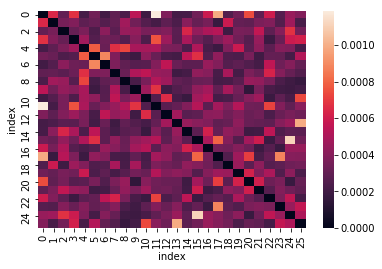

In [23]:
with graph_orig.as_default():
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))

plt.show()

0.09419253


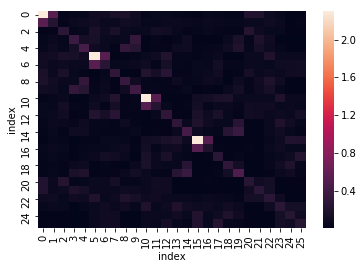

In [24]:
with graph_orig.as_default():
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()

## Enforce hermiticity

In [25]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.norm(reshaped - transposed, axis=(1,2))

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=5e-2)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=1e-6
)
graph_sym = trainer_sym.graph
        

[-] 2018-03-21 00:02:25: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-21 00:02:25: Setting up the training in the target graph ...
[-] 2018-03-21 00:02:25: network ...
[-] 2018-03-21 00:02:25: error function ...
[-] 2018-03-21 00:02:25: cost function ...
[-] 2018-03-21 00:02:25: training step
[-] 2018-03-21 00:02:25: Starting network training ...
[ ] 2018-03-21 00:02:25: Validation cost: 5.80491E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-21 00:02:26: Validation cost: 4.65732E-04. Diff to prev.: 5.8E-02
[ ] 2018-03-21 00:02:26: Validation cost: 4.59620E-04. Diff to prev.: 6.1E-06
[ ] 2018-03-21 00:02:27: Validation cost: 4.39474E-04. Diff to prev.: 2.0E-05
[ ] 2018-03-21 00:02:27: Validation cost: 4.03897E-04. Diff to prev.: 3.6E-05
[ ] 2018-03-21 00:02:28: Validation cost: 4.09724E-04. Diff to prev.: 5.8E-06
[ ] 2018-03-21 00:02:28: Validation cost: 3.00569E-04. Diff to prev.: 1.1E-04
[-] 2018-03-21 00:02:29: Convergence reached after 1400 steps.
[-] 201

0.0010036437


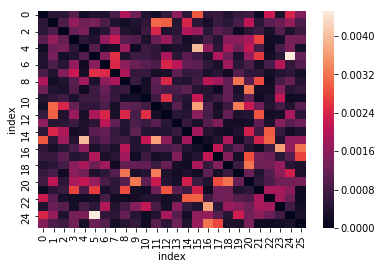

In [26]:
with graph_sym.as_default():
    reshaped = tf.reshape(network_sym.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_sym.run(diff_mean, {network_sym.input_tensor: dataset.testing[0]})
    matrix_error(error)
    print(np.mean(error))

plt.show()

## Enforce idempotency

In [27]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        squared = tf.matmul(reshaped, reshaped)
        
        return tf.norm(reshaped - squared, axis=(1,2))

    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-2)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=5e-7
)
graph_idem = trainer.graph

[-] 2018-03-21 00:02:29: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-21 00:02:29: Setting up the training in the target graph ...
[-] 2018-03-21 00:02:29: network ...
[-] 2018-03-21 00:02:29: error function ...
[-] 2018-03-21 00:02:29: cost function ...
[-] 2018-03-21 00:02:29: training step
[-] 2018-03-21 00:02:30: Starting network training ...
[ ] 2018-03-21 00:02:30: Validation cost: 5.76914E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-21 00:02:30: Validation cost: 1.02828E-02. Diff to prev.: 4.7E-02
[ ] 2018-03-21 00:02:31: Validation cost: 1.02960E-02. Diff to prev.: 1.3E-05
[ ] 2018-03-21 00:02:31: Validation cost: 1.05545E-02. Diff to prev.: 2.6E-04
[ ] 2018-03-21 00:02:32: Validation cost: 1.06102E-02. Diff to prev.: 5.6E-05
[ ] 2018-03-21 00:02:32: Validation cost: 1.04738E-02. Diff to prev.: 1.4E-04
[ ] 2018-03-21 00:02:33: Validation cost: 1.08976E-02. Diff to prev.: 4.2E-04
[ ] 2018-03-21 00:02:33: Validation cost: 1.07990E-02. Diff to prev.: 

0.00080964155


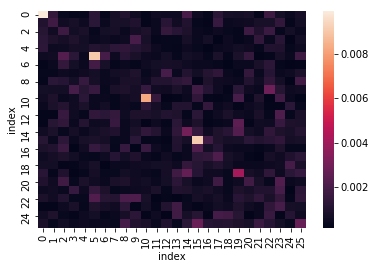

In [28]:
with graph_idem.as_default():
    reshaped = tf.reshape(network_idem.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    error = sess_idem.run(diff_mean, {network_idem.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()
    
    

# Analysis

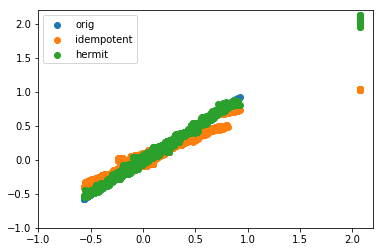

In [29]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

#lower = 1.8
lower = -1
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()
plt.show()

In [33]:
from pyscf.scf import hf

dim = 26

iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s, mean=dataset.x_mean, std=dataset.x_std)[0]
    
    with graph_orig.as_default():
        P_orig = network_orig.run(sess_orig, s).reshape(dim, dim).astype('float64')
        
    with graph_idem.as_default():
        P_idem = network_idem.run(sess_idem, s).reshape(dim, dim).astype('float64')
    
    with graph_sym.as_default():
        P_sym = network_sym.run(sess_sym, s).reshape(dim, dim).astype('float64')
    
    
    # P_actual wi noise
    p_noise = p.reshape(dim, dim) + np.random.randn(dim, dim) * 1e-4
    
    
    iterations_molecule = []
    for guess in [p_noise, P_orig, P_idem, P_sym]:
        
        mf = hf.RHF(mol)
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

Warn: Ipython shell catchs sys.args


Calculating: 1/50


Warn: Ipython shell catchs sys.args


Calculating: 2/50


Warn: Ipython shell catchs sys.args


Calculating: 3/50


Warn: Ipython shell catchs sys.args


Calculating: 4/50


Warn: Ipython shell catchs sys.args


Calculating: 5/50


Warn: Ipython shell catchs sys.args


Calculating: 6/50


Warn: Ipython shell catchs sys.args


Calculating: 7/50


Warn: Ipython shell catchs sys.args


Calculating: 8/50


Warn: Ipython shell catchs sys.args


Calculating: 9/50


Warn: Ipython shell catchs sys.args


Calculating: 10/50


Warn: Ipython shell catchs sys.args


Calculating: 11/50


Warn: Ipython shell catchs sys.args


Calculating: 12/50


Warn: Ipython shell catchs sys.args


Calculating: 13/50


Warn: Ipython shell catchs sys.args


Calculating: 14/50


Warn: Ipython shell catchs sys.args


Calculating: 15/50


Warn: Ipython shell catchs sys.args


Calculating: 16/50


Warn: Ipython shell catchs sys.args


Calculating: 17/50


Warn: Ipython shell catchs sys.args


Calculating: 18/50


Warn: Ipython shell catchs sys.args


Calculating: 19/50


Warn: Ipython shell catchs sys.args


Calculating: 20/50


Warn: Ipython shell catchs sys.args


Calculating: 21/50


Warn: Ipython shell catchs sys.args


Calculating: 22/50


Warn: Ipython shell catchs sys.args


Calculating: 23/50


Warn: Ipython shell catchs sys.args


Calculating: 24/50


Warn: Ipython shell catchs sys.args


Calculating: 25/50


Warn: Ipython shell catchs sys.args


Calculating: 26/50


Warn: Ipython shell catchs sys.args


Calculating: 27/50


Warn: Ipython shell catchs sys.args


Calculating: 28/50


Warn: Ipython shell catchs sys.args


Calculating: 29/50


Warn: Ipython shell catchs sys.args


Calculating: 30/50


Warn: Ipython shell catchs sys.args


Calculating: 31/50


Warn: Ipython shell catchs sys.args


Calculating: 32/50


Warn: Ipython shell catchs sys.args


Calculating: 33/50


Warn: Ipython shell catchs sys.args


Calculating: 34/50


Warn: Ipython shell catchs sys.args


Calculating: 35/50


Warn: Ipython shell catchs sys.args


Calculating: 36/50


Warn: Ipython shell catchs sys.args


Calculating: 37/50


Warn: Ipython shell catchs sys.args


Calculating: 38/50


Warn: Ipython shell catchs sys.args


Calculating: 39/50


Warn: Ipython shell catchs sys.args


Calculating: 40/50


Warn: Ipython shell catchs sys.args


Calculating: 41/50


Warn: Ipython shell catchs sys.args


Calculating: 42/50


Warn: Ipython shell catchs sys.args


Calculating: 43/50


Warn: Ipython shell catchs sys.args


Calculating: 44/50


Warn: Ipython shell catchs sys.args


Calculating: 45/50


Warn: Ipython shell catchs sys.args


Calculating: 46/50


Warn: Ipython shell catchs sys.args


Calculating: 47/50


Warn: Ipython shell catchs sys.args


Calculating: 48/50


Warn: Ipython shell catchs sys.args


Calculating: 49/50


Warn: Ipython shell catchs sys.args


Calculating: 50/50


In [34]:
print(np.mean(iterations,0))

[ 4.86  7.34 10.66  8.88]


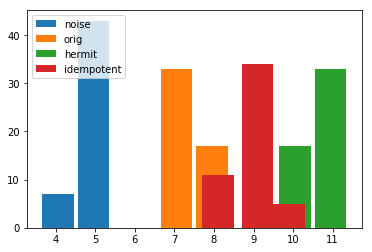

In [35]:

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['noise', 'orig', 'hermit', 'idempotent']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()